In [1]:
! pip install xlrd

    100% |████████████████████████████████| 112kB 3.1MB/s ta 0:00:01


In [1]:
import pandas_profiling as pp
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
! ls -l ../data/original

total 1976272
-rw-rw-r-- 1 ubuntu ubuntu     210907 Jan 25 18:30 1916-2019-01-25-15-00-34.zip
-rw-rw-r-- 1 ubuntu ubuntu    1641746 Jan 25 17:33 atc-icd-mialist.csv
-rw-rw-r-- 1 ubuntu ubuntu    2740224 Jan 25 17:23 BE_COD_2015_FR_v1.xls
-rw-rw-r-- 1 ubuntu ubuntu    2743296 Jan 25 17:23 BE_COD_2015_NL_v2.xls
-rw-rw-r-- 1 ubuntu ubuntu      13946 Jan 25 17:22 Care place service.xlsx
-rw-rw-r-- 1 ubuntu ubuntu    1585669 Jan 25 17:22 csv4Emd_Fr_1901A.zip
-rw-rw-r-- 1 ubuntu ubuntu    1552530 Jan 25 17:22 csv4Emd_Nl_1901A.zip
-rw-rw-r-- 1 ubuntu ubuntu     782180 Jan 25 17:22 csv_ATCDPP_1808A.zip
-rw-rw-r-- 1 ubuntu ubuntu     641368 Jan 25 17:22 csv_VOSDCI_1901A.zip
-rw-rw-r-- 1 ubuntu ubuntu    5330821 Jan 25 17:22 d20061027316.pdf
-rw-rw-r-- 1 ubuntu ubuntu       4243 Jan 25 18:31 dataforbetterhealth-master.zip
-rw-rw-r-- 1 ubuntu ubuntu     152496 Jan 25 17:21 db4emd-docEN.pdf
-rw-r--r-- 1 ubuntu ubuntu 1812381904 Jan 28 11:38 DB_V2.TXT
-rw-rw-r-- 1 ubuntu ubuntu     357479 Jan 25 17

In [4]:
! head ../data/original/DB_V2.TXT

## loading the data

In [2]:
# RIZIV dataset 1.8GB
df = pd.read_csv("../data/original/DB_V2.TXT", sep='\t', encoding='latin-1', low_memory=False)

In [6]:
pp.ProfileReport(df).to_file(outputfile="../data/report/DB_V2_initial_dataset_report.html")

/home/ubuntu/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['

In [3]:
pharma_ref = pd.read_excel("../data/original/PHARMA_REF.xlsx")

In [13]:
pp.ProfileReport(pharma_ref).to_file(outputfile="../data/report/PHARMA_REF_xlsx_initial_dataset_report.html")

/home/ubuntu/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['

In [4]:
reimburse_cat = pd.read_excel("../data/original/reimb category.xlsx")

In [15]:
pp.ProfileReport(reimburse_cat).to_file(outputfile="../data/report/reimb_category_xlsx_initial_dataset_report.html")

/home/ubuntu/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['

## df datacleaning

In [5]:
df.drop('Year', axis=1, inplace=True)
df.drop('account_yy_ss', axis=1, inplace=True)

## pharma_ref datacleaning

In [6]:
pharma_ref["drug_code"] = pharma_ref["drug_code"].astype("category")

## reimburse_cat datacleaning

In [7]:
reimburse_cat_dict = {'nd':'other', 'A':'A', 'B':'B', 'Cat 1':'other', 'Cat 2 (A)':'other', 'Cat 3':'other', 'Cat 4':'other',
       'Cat 5 (D)':'other', 'C':'C', 'Cs':'C', 'Cx':'C', 'Cxg':'C', 'D':'D', 'Csg':'C', 'Ag':'A', 'Bg':'B', 'Cg':'C',
       'Forf Ant':'other', 'Nutri Par':'other', 'Br':'other', 'Ar':'other', 'Cr':'C', 'Csr':'C', 'Cxr':'C',
       'Forf Adm':'other', 'Forf BH':'forf', 'V08':'other', 'Fa':'other', 'Fb':'other', 'Forf 1-3':'other',
       'Forf 4-':'other', 'Ri-D11':'other', 'Ri-T1':'other', 'Ri-T2':'other', 'Ri-T3':'other', 'Ri-D5':'other', 'Ri-D7':'other',
       'Ri-D2':'other', 'Ri-D9':'other', 'Ri-D6':'other', 'Ri-D10':'other', 'Ri-D3':'other', 'Ri-D1':'other', 'Ri-D8':'other',
       'Ri-T4':'other', 'Ri-D4':'other', 'Forf PET':'other', '90-A':'A', '90-B':'B', '90-Fa':'other', '90-Fb':'other',
       'Ri-T5':'other', 'Ri-T6':'other', 'Ri-T7':'other', 'Ri-T8':'other', '90-C':'C', '90-Cs':'C', '90-Cx':'C'}

In [8]:
reimburse_cat["reimbt_crit_long"] = reimburse_cat["reimbt_crit_long"].map(reimburse_cat_dict)

In [9]:
# only keep hospitalised data, ignore ambulant data
reimburse_cat_hosp = reimburse_cat[ (reimburse_cat["patient_cat"] == 'HOSP') ]

In [10]:
# max_pct is highly correlated with min_pct (ρ = 0.98479)
reimburse_cat_hosp.drop('min_pct', axis=1, inplace=True)

/home/ubuntu/venv/lib/python3.5/site-packages/pandas/core/frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [11]:
# patient_cat has constant value HOSP
reimburse_cat_hosp.drop('patient_cat', axis=1, inplace=True)

## MERGE inner joins

In [12]:
df = df.merge(pharma_ref, how="left", left_on="drug_code", right_on="drug_code").reset_index()

In [13]:
df = df.merge(reimburse_cat_hosp, how="left", left_on="reimbt_cat_id", right_on="reimbt_cat_id").reset_index()

## df datacleaning phase II

In [14]:
df.drop("level_0", axis=1, inplace=True)
df.drop("index", axis=1, inplace=True)

In [15]:
# set this columns as datetime dtype
df['date_debut_rembourse'] = pd.to_datetime(df['date_debut_rembourse'], format='%Y-%m-%d')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26009309 entries, 0 to 26009308
Data columns (total 46 columns):
Province                    object
Type                        object
hosp_serv_id                object
reimbt_cat_id               int64
drug_code                   object
realization_date            int64
quantity                    int64
amount_reimb                float64
amount_not_reimb            float64
trim_pharma                 float64
produit_pharma              float64
type_drug_code              object
famille_produit_pharma      object
drug_name_aggregated        object
nom_produit_pharma          object
conditionnement             object
mode_administration         object
nom_firme_pharma            object
date_debut_rembourse        datetime64[ns]
statut_produit_pharma       object
code_atc                    object
code_atc_5                  object
code_atc_4                  object
code_atc_3                  object
code_atc_1                  object
D

In [17]:
df = df.astype({'Type':'category', 'type_drug_code':'category', 'statut_produit_pharma':'category',
               'orphan_flag':'bool', 'chapter_IV_bis_flag':'bool', 'reimbt_cat_acute_yn':'bool',
               'reimbt_cat_chron_yn':'bool', 'reimbt_cat_psy_yn':'bool', 'reimbt_cat_fixed_rate_yn':'bool',
               'relative_care_yn':'bool', 'ami_ziv_amount_null_yn':'bool', 'not_reimbursed_null_yn':'bool', 'fee_cat':'category'})

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26009309 entries, 0 to 26009308
Data columns (total 46 columns):
Province                    object
Type                        category
hosp_serv_id                object
reimbt_cat_id               int64
drug_code                   object
realization_date            int64
quantity                    int64
amount_reimb                float64
amount_not_reimb            float64
trim_pharma                 float64
produit_pharma              float64
type_drug_code              category
famille_produit_pharma      object
drug_name_aggregated        object
nom_produit_pharma          object
conditionnement             object
mode_administration         object
nom_firme_pharma            object
date_debut_rembourse        datetime64[ns]
statut_produit_pharma       category
code_atc                    object
code_atc_5                  object
code_atc_4                  object
code_atc_3                  object
code_atc_1                  ob

In [19]:
df["realization_date"] = df["realization_date"].astype('str')

## Our domain expert suggest to only keep these columns:

In [20]:
# keep these columns:
df = df[['Province', 'Type', 'hosp_serv_id', 'reimbt_cat_id', 'drug_code',
       'realization_date', 'quantity', 'amount_reimb', 'amount_not_reimb',
       'trim_pharma', 'produit_pharma', 'type_drug_code',
       'famille_produit_pharma', 'drug_name_aggregated',
       'conditionnement', 'mode_administration',
       'date_debut_rembourse', 'statut_produit_pharma', 'code_atc',
       'code_atc_5', 'code_atc_4', 'code_atc_3', 'code_atc_1', 'DDD',
       'nombre_prises', 'orphan_flag', 'chapter_IV_bis_flag',
       'link_same_tablet', 'dbegin', 'dend', 'reimbt_cat_desc_fr',
       'reimbt_cat_desc_nl', 'reimbt_crit_long', 'reimbt_crit_short',
       'reimbt_cat_fixed_rate_yn', 'fee_cat']]

## then generate a new final report

In [21]:
pp.ProfileReport(df).to_file(outputfile="../data/report/DB_V4_merged_pharmaref_and_reimbcategory_report.html")

/home/ubuntu/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


## output the final dataset to *.csv format

In [ ]:
df.to_csv("../data/dataset/DB_V4.csv", index=False)

## Select 2016

In [18]:
df = df[ (df["realization_date"].str[:4] == '2016')]

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1542611 entries, 22833075 to 26009296
Data columns (total 46 columns):
Province                    1542611 non-null object
Type                        1542611 non-null object
hosp_serv_id                1542611 non-null object
reimbt_cat_id               1542611 non-null int64
drug_code                   1542611 non-null object
realization_date            1542611 non-null object
quantity                    1542611 non-null int64
amount_reimb                1542611 non-null float64
amount_not_reimb            1542611 non-null float64
trim_pharma                 1542611 non-null float64
produit_pharma              1542611 non-null float64
type_drug_code              1538323 non-null object
famille_produit_pharma      1538323 non-null object
drug_name_aggregated        1538323 non-null object
nom_produit_pharma          1538323 non-null object
conditionnement             1509986 non-null object
mode_administration         1510761 non-null 

## output result

In [20]:
pp.ProfileReport(df).to_file(outputfile="../data/report/DB_V4_2016_report.html")

/home/ubuntu/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['

In [ ]:
#df.to_csv("../data/dataset/DB_V4.csv", index=False)

In [21]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1542611 entries, 22833075 to 26009296
Data columns (total 46 columns):
Province                    1542611 non-null object
Type                        1542611 non-null object
hosp_serv_id                1542611 non-null object
reimbt_cat_id               1542611 non-null int64
drug_code                   1542611 non-null object
realization_date            1542611 non-null object
quantity                    1542611 non-null int64
amount_reimb                1542611 non-null float64
amount_not_reimb            1542611 non-null float64
trim_pharma                 1542611 non-null float64
produit_pharma              1542611 non-null float64
type_drug_code              1538323 non-null object
famille_produit_pharma      1538323 non-null object
drug_name_aggregated        1538323 non-null object
nom_produit_pharma          1538323 non-null object
conditionnement             1509986 non-null object
mode_administration         1510761 non-null 

In [ ]:
#import pandas_profiling as pp

In [ ]:
#pp.ProfileReport(pharma_ref)

In [ ]:
#df["realization_date"] = df["realization_date"].astype('str')

In [ ]:
#(df["realization_date"].str[:4] == '2016').value_counts()

In [22]:
df.columns

Index(['Province', 'Type', 'hosp_serv_id', 'reimbt_cat_id', 'drug_code',
       'realization_date', 'quantity', 'amount_reimb', 'amount_not_reimb',
       'trim_pharma', 'produit_pharma', 'type_drug_code',
       'famille_produit_pharma', 'drug_name_aggregated', 'nom_produit_pharma',
       'conditionnement', 'mode_administration', 'nom_firme_pharma',
       'date_debut_rembourse', 'statut_produit_pharma', 'code_atc',
       'code_atc_5', 'code_atc_4', 'code_atc_3', 'code_atc_1', 'DDD',
       'nombre_prises', 'orphan_flag', 'chapter_IV_bis_flag',
       'link_same_tablet', 'dbegin', 'dend', 'reimbt_cat_desc_fr',
       'reimbt_cat_desc_nl', 'reimbt_crit_long', 'reimbt_crit_short',
       'reimbt_cat_acute_yn', 'reimbt_cat_chron_yn', 'reimbt_cat_psy_yn',
       'max_pct', 'reimbt_cat_fixed_rate_yn', 'relative_care_yn',
       'ami_ziv_amount_null_yn', 'not_reimbursed_null_yn', 'fee_cat',
       'reimbt_cat_id_pk'],
      dtype='object')

In [19]:
# keep these columns:
df = df[['Province', 'Type', 'hosp_serv_id', 'reimbt_cat_id', 'drug_code',
       'realization_date', 'quantity', 'amount_reimb', 'amount_not_reimb',
       'trim_pharma', 'produit_pharma', 'type_drug_code',
       'famille_produit_pharma', 'drug_name_aggregated',
       'conditionnement', 'mode_administration',
       'date_debut_rembourse', 'statut_produit_pharma', 'code_atc',
       'code_atc_5', 'code_atc_4', 'code_atc_3', 'code_atc_1', 'DDD',
       'nombre_prises', 'orphan_flag', 'chapter_IV_bis_flag',
       'link_same_tablet', 'dbegin', 'dend', 'reimbt_cat_desc_fr',
       'reimbt_cat_desc_nl', 'reimbt_crit_long', 'reimbt_crit_short',
       'reimbt_cat_fixed_rate_yn', 'fee_cat']]

In [20]:
df["reimbt_cat_fixed_rate_yn"] = df["reimbt_cat_fixed_rate_yn"].astype('bool')

In [21]:
df_work = df[ (df["reimbt_cat_fixed_rate_yn"] == True) ]

In [38]:
df_work.to_csv("../data/dataset/not_reimb_workfile_2016.csv", index=False)

In [40]:
df_work["Type"].value_counts()

Général          953388
Psychiatrique      6046
Name: Type, dtype: int64

In [63]:
df_work["amount_reimb_div_quantity"] = df_work["amount_reimb"] / df_work["quantity"]

/home/ubuntu/venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
#df.groupby('col1')['col2'].apply(lambda x: x)

In [41]:
df_work = df_work[ (df_work["Type"] == "Général") ]

In [68]:
df_work.groupby(["code_atc"])["amount_reimb_div_quantity"].sum().value_counts(ascending=False)

 0.000000e+00    520
 inf             101
-inf              13
 5.824304e+00      1
 5.003638e+02      1
 4.261144e+00      1
 4.202902e+01      1
 4.718318e+01      1
 3.732954e+02      1
 6.304515e+01      1
 5.873456e+02      1
 8.036152e+00      1
 9.219011e+04      1
 2.022065e+04      1
 9.989872e+03      1
 3.684756e+01      1
 1.139832e+01      1
 4.038665e+03      1
 2.662045e-01      1
 2.348433e+01      1
 9.977944e+03      1
 7.716923e+01      1
 2.796620e+03      1
 7.934648e+00      1
 8.849044e+01      1
 1.206362e+02      1
 2.878000e+01      1
 1.138605e+04      1
 3.721350e+03      1
 2.942728e+02      1
                ... 
 3.865374e+04      1
 1.041316e+06      1
 2.406465e+01      1
 7.219843e+00      1
 4.166468e+01      1
 3.284791e+01      1
 2.573558e+00      1
 4.382187e+00      1
 1.281722e+05      1
 4.841690e+02      1
 4.057019e+01      1
 6.042004e+03      1
 6.111199e+01      1
 2.092393e+05      1
 7.775758e+02      1
 1.050866e+04      1
 2.576000e+02

In [46]:
df_work.groupby(["code_atc"]).value_counts()

AttributeError: 'DataFrameGroupBy' object has no attribute 'value_counts'

In [27]:
df_work.sample(5).T

,25278167,23545790,23272318,24872023,23028290
Province,Flandre orientale,Flandre Occidentale,Bruxelles-Capitale,Bruxelles-Capitale,Anvers
Type,Général,Général,Général,Général,Général
hosp_serv_id,620,230,990,730,230
reimbt_cat_id,756066,756125,750934,751015,757864
drug_code,742445,700773,7703333,1406453,727271
realization_date,20164,20163,20161,20164,20162
quantity,41,49,6,1068,2
amount_reimb,0.76,15.88,12.48,0,1.38
amount_not_reimb,0,0,3.77,763.61,0
trim_pharma,20183,20183,20183,20183,20183


In [23]:
df_work.statut_produit_pharma.unique()

array([nan, 'G', 'orig', 'orig R'], dtype=object)

In [24]:
statut_produit_pharma_dict = {'G':True, 'orig':False, 'orig R':True}

In [26]:
df_work["B_IsGeneric"] = df_work["statut_produit_pharma"].map(statut_produit_pharma_dict)

/home/ubuntu/venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [29]:
df_work["B_IsGeneric"].value_counts(normalize=True)

True     0.509418
False    0.490582
Name: B_IsGeneric, dtype: float64

In [33]:
generic = df_work.groupby(["code_atc_1"])["B_IsGeneric"].value_counts(normalize=True)
generic

code_atc_1  B_IsGeneric
A           False          0.540738
            True           0.459262
B           False          0.962066
            True           0.037934
C           True           0.771700
            False          0.228300
D           False          0.938807
            True           0.061193
G           False          0.588580
            True           0.411420
H           False          0.548688
            True           0.451312
J           True           0.760785
            False          0.239215
L           False          0.510983
            True           0.489017
M           True           0.728268
            False          0.271732
N           True           0.665850
            False          0.334150
P           False          0.645973
            True           0.354027
R           True           0.704271
            False          0.295729
S           False          0.636908
            True           0.363092
V           False          0.921120
    

In [54]:
generic.index

MultiIndex(levels=[['A', 'B', 'C', 'D', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'V', 'X', 'Z'], [False, True]],
           codes=[[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 15], [0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0]],
           names=['code_atc_1', 'B_IsGeneric'])

In [44]:
newgeneric = pd.DataFrame()

In [68]:
newgeneric["percentageOfGeneric"] = generic.values

In [57]:
newgeneric["ATC"] = pd.Series(['A', 'B', 'C', 'D', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'V', 'X', 'Z'])

In [ ]:
newgeneric

In [34]:
import seaborn as sns

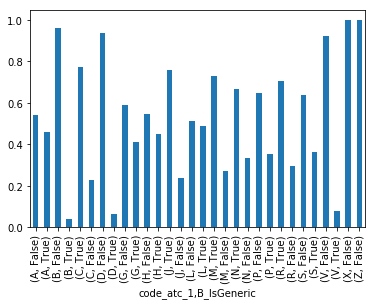

In [35]:
generic.plot(kind="bar")

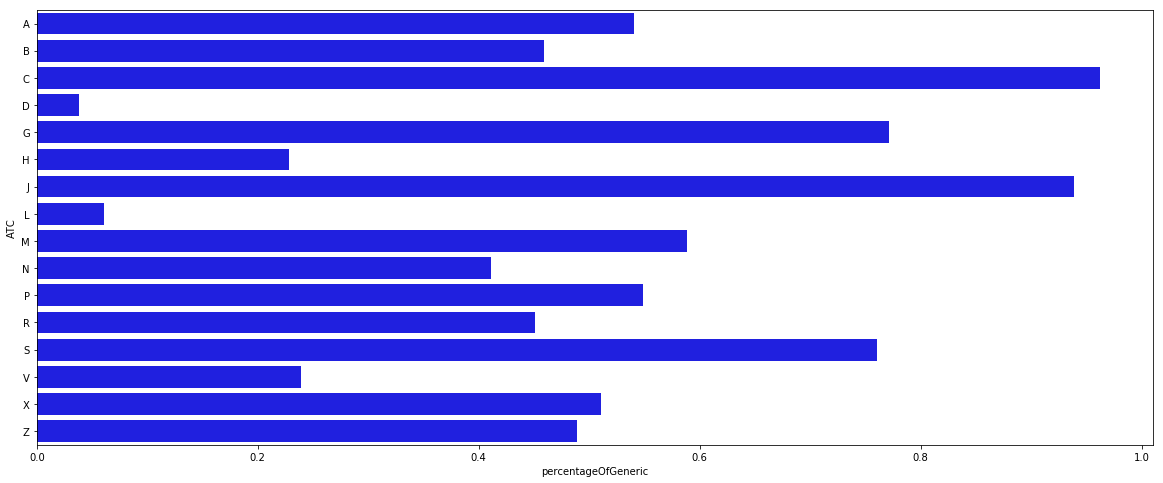

In [84]:
plt.figure(figsize=(20,8))
sns.barplot(data=newgeneric, x="percentageOfGeneric", y="ATC", color='blue' )

In [70]:
genericByService = df_work.groupby(["hosp_serv_id"])["B_IsGeneric"].value_counts(normalize=True)
genericByService

hosp_serv_id  B_IsGeneric
2             False          0.628992
              True           0.371008
190           False          0.605381
              True           0.394619
210           True           0.616735
              False          0.383265
220           True           0.604873
              False          0.395127
230           True           0.584108
              False          0.415892
250           True           0.590588
              False          0.409412
260           True           0.510317
              False          0.489683
270           False          0.549520
              True           0.450480
290           True           0.565955
              False          0.434045
300           True           0.636112
              False          0.363888
320           False          0.671159
              True           0.328841
340           True           0.665946
              False          0.334054
350           True           0.640741
              False     

In [71]:
genericByService.index

MultiIndex(levels=[[2, 190, 210, 220, 230, 250, 260, 270, 290, 300, 320, 340, 350, 370, 380, 490, 610, 620, 630, 640, 650, 660, 710, 720, 730, 740, 750, 760, 770, 810, 840, 990, '002', '190', '210', '220', '230', '260', '270', '290', '300', '320', '340', '370', '380', '490', '610', '620', '630', '640', '650', '710', '720', '730', '750', '760', '770', '840', '990'], [False, True]],
           codes=[[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32, 32, 33, 33, 34, 34, 35, 35, 36, 36, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 42, 42, 43, 43, 44, 44, 45, 45, 46, 46, 47, 47, 48, 48, 49, 49, 50, 50, 51, 51, 52, 52, 53, 53, 54, 54, 55, 55, 56, 56, 57, 57, 58, 58], [0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,

In [72]:
newgenericByService = pd.DataFrame()

In [73]:
newgenericByService["percentageOfGeneric"] = genericByService.values

In [78]:
newgenericByService["Service"] = pd.Series([2, 190, 210, 220, 230, 250, 260, 270, 290, 300, 320, 340, 350, 370, 380, 490, 610, 620, 630, 640, 650, 660, 710, 720, 730, 740, 750, 760, 770, 810, 840, 990, 2, 190, 210, 220, 230, 250, 260, 270, 290, 300, 320, 340, 350, 370, 380, 490, 610, 620, 630, 640, 650, 660, 710, 720, 730, 740, 750, 760, 770, 810, 840, 990])

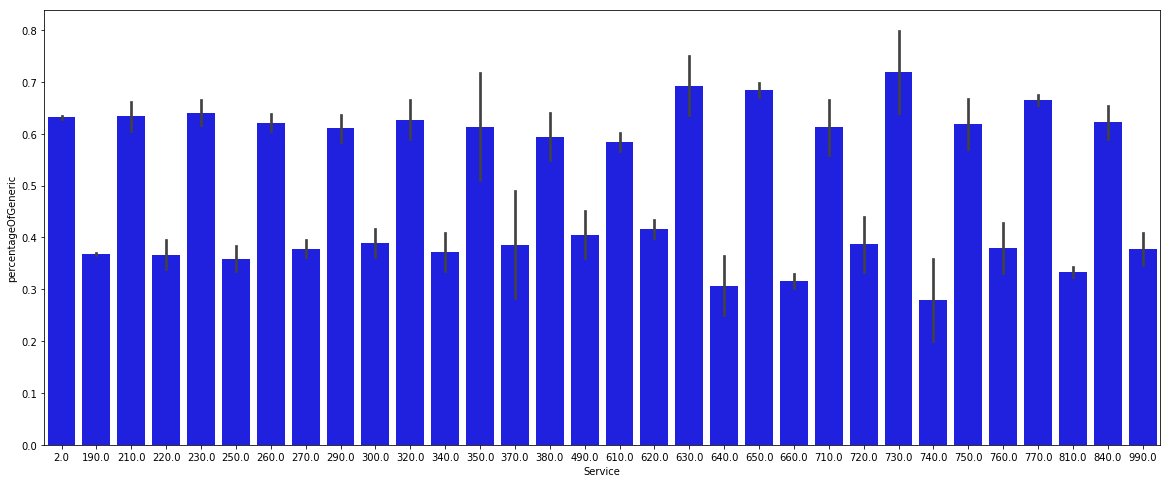

In [82]:
plt.figure(figsize=(20,8))
sns.barplot(data=newgenericByService, y="percentageOfGeneric", x="Service", color='blue' )